In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

Val_zy = []      # Points with hits
new_Val_zy = []  # After removing outliers
Ang = []         # Angles (in rad)
Ex=[]            # events thrown out (excluded)

# a linear function z=A-y*tan(a)
def path_yz(a,y,A):
    return A - np.tan(a)*y

def rough_minimize_path_yz(a,A):
    Sum = 0
    for i in range(len(Val_zy)):
        res = (Val_zy[i][0]-path_yz(a,Val_zy[i][1],A))
        Sum = Sum + res**2
    return Sum

# calculates distance from fit and throws outliers during fit
def minimize_path_yz(a,A):
    Sum = 0
    new_Val_zy.clear()
    for i in range(len(Val_zy)):
        y_p = ((A-Val_zy[i][0])*np.sin(2*a)/2+Val_zy[i][1])*(np.cos(a))**2   # point on fit closest to hit
        dist = np.sqrt((Val_zy[i][0]-path_yz(a,y_p,A))**2 + (Val_zy[i][1]-y_p)**2)
        if dist<15:
            new_Val_zy.append([Val_zy[i][0],Val_zy[i][1]])
            res = (Val_zy[i][0]-path_yz(a,Val_zy[i][1],A))
            Sum = Sum + res**2
    return Sum

# should be redundant (but sometimes isn't for some reason)
def final_minimize_path_yz(a,A):
    Sum = 0
    for i in range(len(new_Val_zy)):
        res = (new_Val_zy[i][0]-path_yz(a,new_Val_zy[i][1],A))
        Sum = Sum + res**2
    return Sum

Welcome to JupyROOT 6.24/08


In [2]:
#Load Root File
Run=4177
file=ROOT.TFile(f"AngDist/SFGFlatTrees/SFGFlat_{Run}/output/SFGFlat_{Run}_0.root","OLD") 

#Load Tree names "HitInfo"
tree=file.Get("HitInfo") 

# Loop through branches and print their names:
branch_list = tree.GetListOfBranches()
treename=tree.GetName()    
# Get number of Events in Tree:
nevents=tree.GetEntries()

In [11]:
Ang.clear()
aneventYZ=ROOT.TH2D("aneventYZ","",182,1,183,56,1,57) #a 2D histogram to store

for event in range(nevents):
    # fills Val_zy with an event
    tree.Draw("ypos:zpos >> aneventYZ",f"pe_side*(eventNumber=={event} && pe_side>10)","colz")
    Val_zy.clear()
    for BinZ in range(1,183):
        for BinY in range(1,57):
            content=aneventYZ.GetBinContent(BinZ,BinY)
            if content>10:
                Val_zy.append([BinZ,BinY])
                
    if len(Val_zy) > 20: 
        # rough fit
        rough_fit_Min = Minuit(rough_minimize_path_yz, a=0, A=91)
        rough_fit_Min.migrad()
        
        # middle refined fit
        mfit_Min = Minuit(minimize_path_yz, a=rough_fit_Min.values['a'], A=rough_fit_Min.values['A'])
        mfit_Min.migrad()
        
        if len(new_Val_zy) > 7: # makes sure there's still enough data to fit
            # refined fit
            fit_Min = Minuit(final_minimize_path_yz, a=mfit_Min.values['a'], A=mfit_Min.values['A'])
            fit_Min.migrad()
            
            # forces -pi/2 < angle < pi/2 
            while fit_Min.values['a']<-np.pi/2 or fit_Min.values['a']>np.pi/2: 
                if fit_Min.values['a']<-np.pi/2:
                    fit_Min.values['a'] += np.pi
                elif fit_Min.values['a']>np.pi/2:
                    fit_Min.values['a'] += -np.pi
            Ang.append(fit_Min.values['a'])
            
        else:
            Ex.append(event)

len(Ang)

KeyboardInterrupt: 

Warning in <TFile::Append>: Replacing existing TH1: aneventYZ (Potential memory leak).


In [12]:
len(Ang)

3477

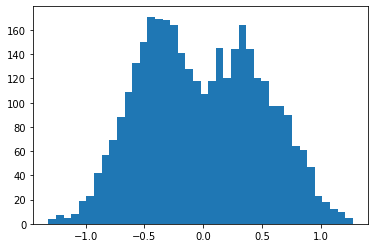

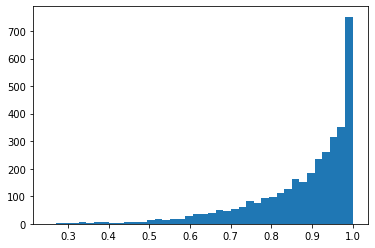

In [13]:
# Distribution of angles

plt.hist(Ang, bins=40)
plt.show()

plt.hist(np.cos(Ang), bins=40)
plt.show()

In [14]:
len(Ex)

170

In [15]:
# Fraction thrown out
len(Ex)/event

0.04665203073545554